## Reference
This notebook is an excerpt from Matthew Drury's `time-series-lecture.ipynb`.

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Always make it pretty.
plt.style.use('ggplot')

# prevents integer -> float typecast warning from sklearn.
import warnings
warnings.filterwarnings('ignore')

# Time Series - Fundamental Conceps

A *time series* is a specific type of data, where measurements of a single quantity are taken over time.

When speaking in equations, we will generally represent time with an index $i$, and the observations from the series as $y_i$.  So the time series as a whole is

$$y_1, y_2, y_3, \ldots $$

### Examples

A good source for time series data is [google trends](https://www.google.com/trends/) where you can find how the popularity of a search term varies over time:

We've provided some chosen google trends in the `data` directory.

In [2]:
def load_google_trend_data(name):
    """Load saved data for a google trend.
    
    NOTE: For this to work you need to have started your notebook from the
    lecture directory.
    """
    file_name = os.path.join('.', 'data', ''.join(['search-index-', name, '.txt']))
    df = pd.read_csv(file_name)
    df = df.set_index(pd.DatetimeIndex(df.week))
    del df['week']
    return pd.Series(df[name], df.index)

Let's plot these trends and look for some interesting patterns.

In [3]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series)
    ax.set_title("Google Search Trend For {}".format(name))

In [4]:
google_search_names = ['baseball', 'python', 'pokemon', 'taxes', 'gdp', 'gmail', 'blackberry']

google_trends = {
    name: load_google_trend_data(name)
    for name in google_search_names
}

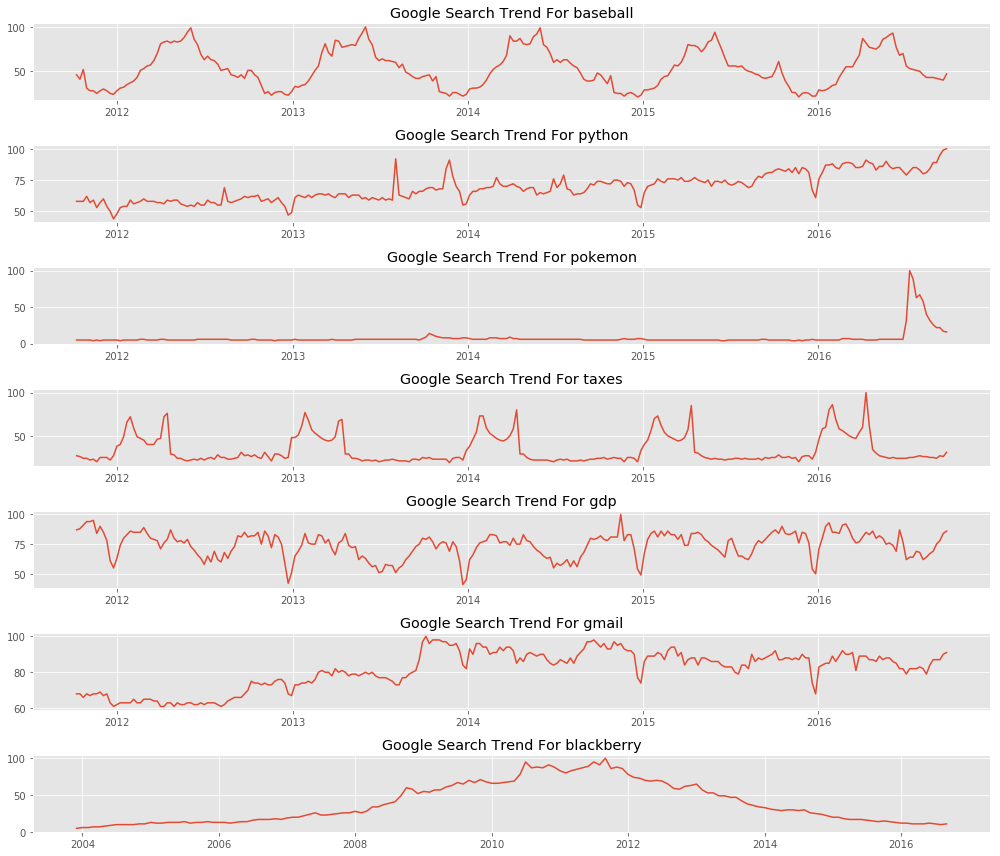

In [5]:
fig, axs = plt.subplots(len(google_trends), figsize=(14, 12))

for ax, name in zip(axs, google_search_names):
    plot_trend_data(ax, name, load_google_trend_data(name))
    
plt.tight_layout()

Some observations:

  - Searches for **baseball** show very strong oscillations aligned with the baseball season.  Search volume increases quickly as the season begins, and then falls off as the season goes on.
  - Searches for **python** show a general increase over time, probably influenced by the popularity of the language itself.  There may be evidence that searches decrease as specific periods of the year, most noticeably the end of year, when people are not working.
  - Searches for **pokemon** spike suddenly at a recent date, pointing to a one-time event greatly increasing interest.
  - Searches for **taxes** spike regularly at two specific points of the year, with the interest being heightened between those two dates.  At other times of the year, searches revert to a low rate.
  - Searches for **gdp** show a more random pattern than the others.  There is some evidence for *stickiness* in the trend, low values beget low subsequent values, and high values beget high subsequent values.
  - Searches for **gmail** show a pattern reminiscent of python, but there are sudden shifts where the baseline level jumps to a new value.
  - Searches for **blackberry** have a non-linear trend over time, they increase to a peak popularity, then decrease to almost nothing.

**Activity:** Load and plot the trend data for "data-science", what patterns do you see?

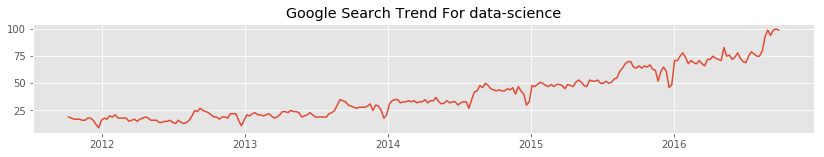

In [6]:
fig = plt.figure(figsize=(14,2))
ax = plt.subplot(111)
plot_trend_data(ax, 'data-science', load_google_trend_data('data-science'))

## Basic Concepts

Various different time series often show common patterns.  Attaching words to these patterns allows us to build a common language to discuss time series.

### Trends

**A trend in a time series is a gradual change in average level as time moves on.**  

A trend an be *increasing*, *decreasing*, or *neither* (if, for example, a trend changes direction at some point in time). 

Searches for **python** show a steady increasing trend.

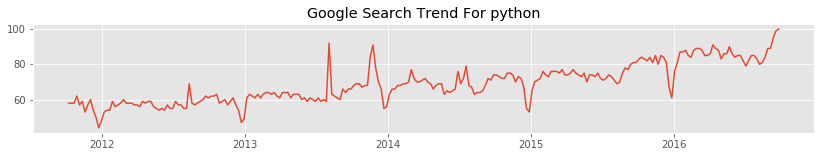

In [7]:
fig, ax = plt.subplots(1, figsize=(14, 2))
plot_trend_data(ax, 'python', google_trends['python'])

Searches for **blackberry** show a non-linear trend.

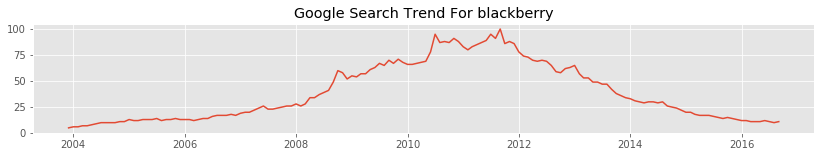

In [8]:
fig, ax = plt.subplots(1, figsize=(14, 2))
plot_trend_data(ax, 'blackberry', google_trends['blackberry'])

**Question:** How you you describe the trend in `data-science`?

You can often use a regression model to capture a general trend in the series.

Let's try to capture the linear trend in the python search data by fitting a simple linear model and using its predictions on the training data.

In [9]:
def to_col_vector(arr):
    """Convert a one dimensional numpy array to a column vector."""
    return arr.reshape(-1, 1)

def make_design_matrix(arr):
    """Construct a design matrix from a numpy array, including an intercept term."""
    return sm.add_constant(to_col_vector(arr), prepend=False)

def fit_linear_trend(series):
    """Fit a linear trend to a time series.  Return the fit trend as a numpy array."""
    X = make_design_matrix(np.arange(len(series)) + 1)
    linear_trend_ols = sm.OLS(series.values, X).fit()
    linear_trend = linear_trend_ols.predict(X)
    return linear_trend

def plot_linear_trend(ax, name, series):
    linear_trend = fit_linear_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, linear_trend)

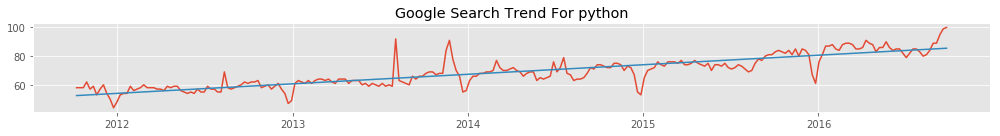

In [10]:
fig, ax = plt.subplots(1, figsize=(14, 2))
plot_linear_trend(ax, 'python', google_trends['python'])
plt.tight_layout()

If we subtract out the fit trend from the original series, we get the **detrended series**.

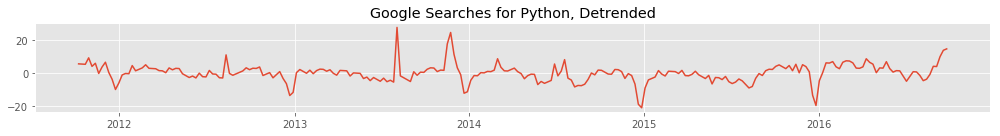

In [11]:
python_series = google_trends['python']
python_linear_trend = fit_linear_trend(python_series)
# the detrending:
python_series_detrended = python_series - python_linear_trend

fig, ax = plt.subplots(1, figsize=(14, 2))
ax.plot(python_series_detrended.index, python_series_detrended)
ax.set_title("Google Searches for Python, Detrended")
plt.tight_layout()

Detrending a series is often times a first step in analysing a time series.  

There are other methods you could use to detrend a time series (see the `time-series-lecture.ipynb` for more).

### Seasonality

A **seasonal** pattern in a time series is one that tends to appear regularly, and aligns with features of the calendar.

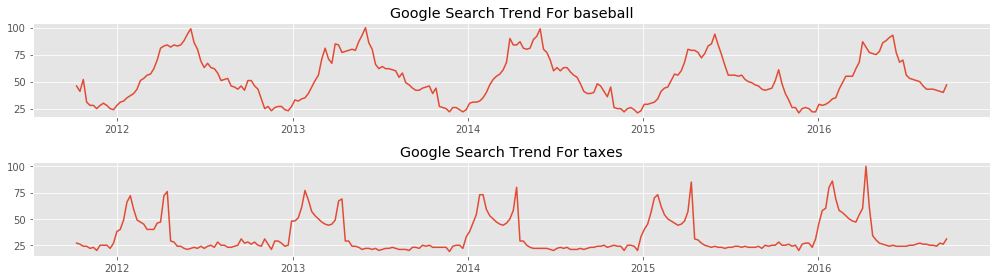

In [12]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_trend_data(axs[0], 'baseball', google_trends['baseball'])
plot_trend_data(axs[1], 'taxes', google_trends['taxes'])
plt.tight_layout()

Just like we can **detrend** a time series, we can also **deseasonalize** a time series.

The simplest method is to create dummy variables at regular intervals of the calender
  - A dummy for each month.
  - A dummy for each season.
  
and then fit a linear regression to the series using these dummy variables.

In [13]:
def create_monthly_dummies(series):
    month = series.index.month
    # Only take 11 of the 12 dummies to avoid strict collinearity.
    return pd.get_dummies(month).ix[:, :11]

def fit_seasonal_trend(series):
    dummies = create_monthly_dummies(series)
    X = sm.add_constant(dummies.values, prepend=False)
    seasonal_model = sm.OLS(series.values, X).fit()
    return seasonal_model.predict(X)

def plot_seasonal_trend(ax, name, series):
    seasons_average_trend = fit_seasonal_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, seasons_average_trend)

Here are linear regression models fit to the baseball and taxes trends with monthly dummy variables.

In [14]:
# show what the above functions do
print(google_trends['baseball'][:5])
baseball_weekly = create_monthly_dummies(google_trends['baseball'])
print('\n')
print(baseball_weekly[:5])

week
2011-10-08    46
2011-10-15    41
2011-10-22    52
2011-10-29    31
2011-11-05    28
Name: baseball, dtype: int64


   1   2   3   4   5   6   7   8   9   10  11
0   0   0   0   0   0   0   0   0   0   1   0
1   0   0   0   0   0   0   0   0   0   1   0
2   0   0   0   0   0   0   0   0   0   1   0
3   0   0   0   0   0   0   0   0   0   1   0
4   0   0   0   0   0   0   0   0   0   0   1


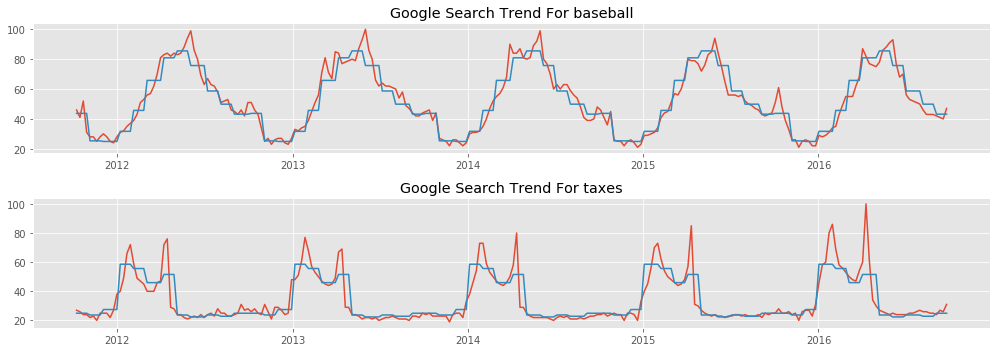

In [15]:
fig, axs = plt.subplots(2, figsize=(14, 5))

plot_seasonal_trend(axs[0], 'baseball', google_trends['baseball'])
plot_seasonal_trend(axs[1], 'taxes', google_trends['taxes'])
plt.tight_layout()

To deseasonalize, we simply subtract out the seasonal predictions.

Text(0.5, 1.0, 'Google Searches for Baseball, Deseasonalized')

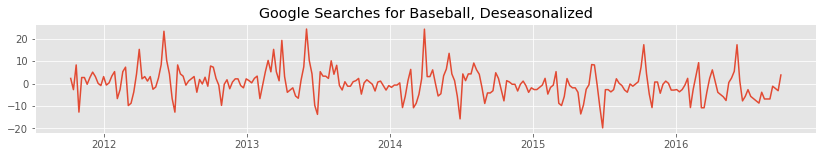

In [16]:
baseball_series = google_trends['baseball']
baseball_seasonal_trend = fit_seasonal_trend(baseball_series)
# deseasonalize
baseball_seasonal_detrended = baseball_series - baseball_seasonal_trend

fig, ax = plt.subplots(1, figsize=(14, 2))
ax.plot(baseball_series.index, baseball_seasonal_detrended)
ax.set_title("Google Searches for Baseball, Deseasonalized")

Text(0.5, 1.0, 'Google Searches for Taxes, Deseasonalized')

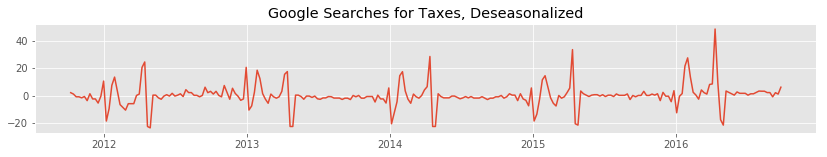

In [17]:
baseball_series = google_trends['taxes']
baseball_seasonal_trend = fit_seasonal_trend(baseball_series)
#deseasonalize
baseball_seasonal_detrended = baseball_series - baseball_seasonal_trend

fig, ax = plt.subplots(1, figsize=(14, 2))
ax.plot(baseball_series.index, baseball_seasonal_detrended)
ax.set_title("Google Searches for Taxes, Deseasonalized")

## Trend-Seasonal-Residual Decomposition

The **Classical Trend-Seasonal-Residual Decomposition** expresses a time series as the sum of three components:

$$ y_t = T_t + S_t + R_t $$

and is accomplished as follows.

Suppose, for definiteness, that we are working with *weekly* data, so that each $52$ observations forms a calender year.  Then, the series is decomposed as follows:

1. Compute the trend component $T_t$ using a moving average with window width $52$ (or $12$ for monthly data.  Then detrend the series.
2. Compute the seasonal component $S_t$ of the detrended series $y_t - T_t$ by averaging together the observations that fall in the same week (or month, if monthly data).  **Note**, this is *equivalent* to fitting a linear regression to the detrended data with an indicator for each week, and then making predictions for each week of the original series.
3. The **remainder**, or **error**, or **residual** series $E_t$ is $y_t - T_t - S_t$.

Statsmodels implements the classical decomposition as `seasonal_decompose`.

In [18]:
python_decomposition = sm.tsa.seasonal_decompose(google_trends['python'])

In [19]:
def plot_seasonal_decomposition(axs, series, sd):
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")

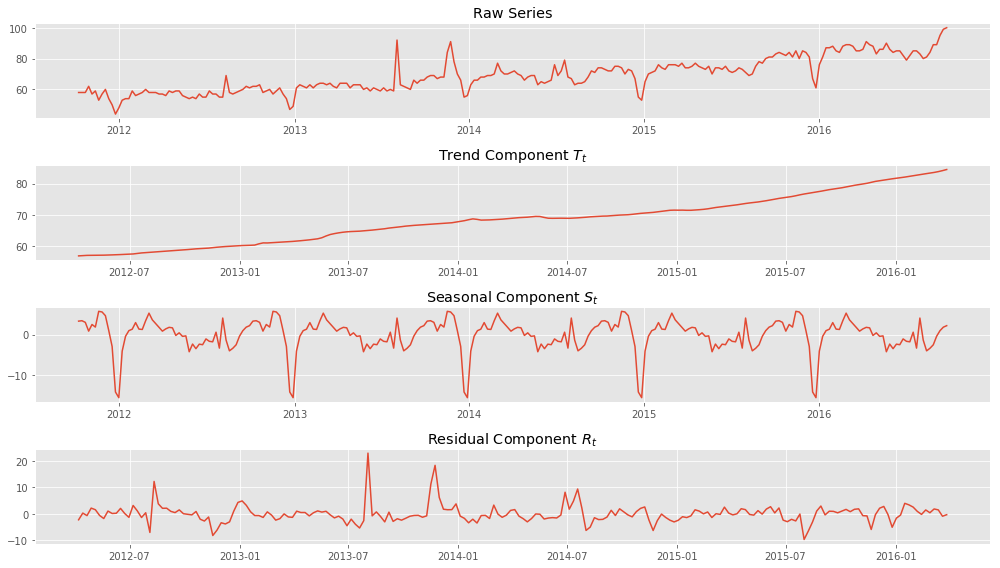

In [20]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, google_trends['python'], python_decomposition)
plt.tight_layout()

This decomposition validates our description of the series earlier as a general upwards trend, but with some seasonal behaviour (like a sharp drop off in queries around wintertime).

When the decomposition is working well, the residual component $R_t$ should show no seasonal or trend patterns.